# NEON Paper Plots (Climatology) 
## Figure 3: Annual Flux climatology 
  + Figure 3 Alternative (boxplot)
##### Author : Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513)

##### Last revised: 2022-09-29
_______

## Creating Climatology Plots for NEON sites

This notebooks have the scripts for:

1. Reading Evaluation (NEON) and model (CTSM) data for all neon sites
2. Making climatology figures
* time-series with standard deviation as shaded regions 
* boxplots 


Creating plots for all sites using 16 dask workers will take ~45 minutes. 

# Imports:

In [1]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import calendar

import tqdm
import cftime
from neon_utils import download_eval_files

import seaborn as sns ## -- seaborn only needed for boxplots:


In [2]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 2022.6.0


## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
16 workers worked best for NEON.

In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43839 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/new_server/proxy/43839/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/new_server/proxy/43839/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:46775,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/new_server/proxy/43839/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Useful Functions and Objects

In [4]:
def shaded_tseries( df_daily, df_daily_std, var, ax, color1= '#e28743',color2='#1d657e'):
    
    plot_var = var.obs_var
    sim_var = var.sim_var
    plot_var_desc = var.long_name
    plot_var_unit = var.unit
    
    ax.plot ( df_daily.time, df_daily[sim_var], marker = 'o' , linestyle ='dashed', color = color2, label="CTSM", alpha = 0.9)
    ax.plot ( df_daily.time, df_daily[plot_var], marker = 'o' , color = color1,label="NEON", alpha = 0.9)
    
    ax.fill_between(df_daily.time, df_daily[plot_var]-df_daily_std[plot_var], df_daily[plot_var]+df_daily_std[plot_var] ,alpha=0.15, color = color1)
    ax.fill_between(df_daily.time, df_daily[sim_var]-df_daily_std[sim_var], df_daily[sim_var]+df_daily_std[sim_var] ,alpha=0.15, color = color2)

    ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
    ax.margins(x=0.02)

    
    
def climatology_tseries_allvars_fig3 (fig,  df_daily, df_daily_std, all_vars, plot_dir, color1= '#e28743',color2='#1d657e' , save_switch=False):
        panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]

        axes = fig.subplots(nrows=5, ncols=1)
        axe = axes.ravel()

        for index, var in enumerate(all_vars):
            ax = axe[index]
            
            shaded_tseries ( df_daily, df_daily_std, var, ax,color1,color2)
            
            ax.text(.025,0.90,panel_labels[index],
                horizontalalignment='left',
                transform=ax.transAxes, fontweight='bold',fontsize=19)


            # Set the locator for boxplots
            locator = mdates.MonthLocator()  # every month
            
            # Specify the format - %b gives us Jan, Feb...
            fmt = mdates.DateFormatter('%b')            

            if index == 0:
                ax.text(.5,1.03,'NEON site : '+neon_site + ' [2018-2021]',
                horizontalalignment='center',
                transform=ax.transAxes, fontweight='bold',fontsize=19)
                ax.legend(fontsize = 17)


            ax.tick_params(axis='both', which='both', labelsize=17,width=1,length=7)
            ax.tick_params(axis='x',direction="in", length = 7)
            ax.yaxis.set_ticks_position('both')
            ax.tick_params(axis='y',direction="out", length = 7)
            
            X=ax.xaxis
            X.set_major_locator(locator)
            X.set_major_formatter(fmt)
            
            ax.get_yaxis().set_label_coords(-0.05,0.5)

            if index == 5:
                X = plt.gca().xaxis
                X.set_major_locator(locator)
                X.set_major_formatter(fmt)

        ax.set_xlabel('Month', fontsize=17)
        fig.subplots_adjust(wspace=0, hspace=0)

        if save_switch:
            
            plot_name = neon_site+'_'+'climatology_tseries'+'_'+'allvars.png'
            plot_dir1 = os.path.join(plot_dir, 'climatology_tseries_final', 'png')
            if not os.path.isdir(plot_dir1):
                os.makedirs(plot_dir1, exist_ok=True)            
            
            print ('Saving '+ os.path.join(plot_dir1,plot_name))
            plt.savefig (os.path.join(plot_dir1,plot_name), dpi=600,bbox_inches='tight') 
            
            
            
            #plot_name = neon_site+'_'+'climatology_tseries'+'_'+'allvars.eps'
            #plot_dir = "/glade/work/negins/neon_vis_plots/paper_plots/climatology_tseries_final/eps/"
            #if not os.path.isdir(plot_dir):
            #    os.mkdir(plot_dir)            

            
            #print ('Saving '+ os.path.join(plot_dir,plot_name))
            #plt.savefig (os.path.join(plot_dir,plot_name), dpi=600,bbox_inches='tight', format = 'eps') 
            
            
            plot_name = neon_site+'_'+'climatology_tseries'+'_'+'allvars.pdf'
            plot_dir2 = os.path.join(plot_dir, 'climatology_tseries_final', 'pdf')
            if not os.path.isdir(plot_dir2):
                os.makedirs(plot_dir2, exist_ok=True)            

            
            print ('Saving '+ os.path.join(plot_dir2,plot_name))
            plt.savefig (os.path.join(plot_dir2,plot_name), dpi=600,bbox_inches='tight', format = 'pdf')  
        else:
            plt.show()
            
def climatology_boxplots_allvars_alt_fig3(fig,  df_daily, df_daily_std, all_vars,plot_dir,  color1 = "darkorange",color2= "steelblue", save_switch=False):
        axes = fig.subplots(nrows=5, ncols=1)
        axe = axes.ravel()

        index = 0
        for var in all_vars:
            plot_var = var.obs_var
            sim_var = var.sim_var
            plot_var_desc = var.long_name
            plot_var_unit = var.unit

            df_plot = df_daily.melt(id_vars='month', value_vars=[plot_var, sim_var])
            df_plot['month'] = df_plot['month'].apply(lambda x: calendar.month_abbr[x])

            ax = axe[index]

            my_pal = {plot_var: color1, sim_var: color2}

            ax = sns.boxplot(x='month', y='value', hue='variable', data=df_plot,ax=ax,width =0.513,linewidth=3,showfliers = False,palette=my_pal, showmeans= True,
                            meanprops=dict(marker='o', markeredgecolor='black',markerfacecolor='white',markersize=7.5),)
            legend_labels, _= ax.get_legend_handles_labels()



            index = index+1

            #-- Set the locator for box plots
            locator = mdates.MonthLocator()  # every month
            #-- Specify the format - %b gives us Jan, Feb...
            fmt = mdates.DateFormatter('%b')

            if index == 1:

                ax.text(.5,1.03,'NEON site : '+neon_site + ' [2018-2021]',
                horizontalalignment='center',
                transform=ax.transAxes, fontweight='bold',fontsize=19)
                ax.legend(legend_labels, ['NEON','CTSM'],fontsize=19)

            else:
                ax.get_legend().remove()


            ax.tick_params(axis='both', which='both', labelsize=17,width=1,length=7)
            ax.tick_params(axis='x',direction="in", length = 7)
            ax.yaxis.set_ticks_position('both')
            ax.tick_params(axis='y',direction="out", length = 7)
            
            
            ax.get_yaxis().set_label_coords(-0.035,0.5)
            ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)


        ax.set_xlabel('Month', fontsize=17)

        fig.subplots_adjust(wspace=0, hspace=0)


        if save_switch:
            plot_name = neon_site+'_'+'climatology_boxplots'+'_'+'allvars.png'
            plot_dir = os.path.join(plot_dir, 'climatology_boxplots_final', 'png')
            
            if not os.path.isdir(plot_dir):
                os.makedirs(plot_dir, exist_ok=True)            
            
            print ('Saving '+ os.path.join(plot_dir,plot_name))
            plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')     
        else:
            plt.show()
            


In [5]:
class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name


## Variables to create plots

Create a list of variables instances for the plots. 

In [6]:
all_vars= [] 

plot_var = 'Rnet'
sim_var = 'sim_'+plot_var
plot_var_desc = "Net Radiation"
plot_var_unit= "W m⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'FSH'
sim_var = 'sim_'+plot_var
plot_var_desc = 'Sensible Heat Flux'
plot_var_unit= "W m⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'EFLX_LH_TOT'
sim_var = 'sim_'+plot_var
plot_var_desc = "Latent Heat Flux"
plot_var_unit= "W m⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)



plot_var = 'GPP'
sim_var = 'sim_'+plot_var
plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)


plot_var = 'NEE'
sim_var = 'sim_'+plot_var
plot_var_desc = "Net Ecosystem Exchange"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

---------------------------
## Make Climatology Figure

In [7]:
# -- read list of sites:
#neon_sites_pft = pd.read_csv('/glade/scratch/negins/preprocessed_neon_csv_data/neon_sites_dompft.csv')
neon_sites_pft = pd.read_csv('/glade/scratch/wwieder/run_NEON_v2/tools/site_and_regional/neon_sites_dompft.csv')
neon_sites = neon_sites_pft['Site'].to_list()

failed_sites = [] # -- list for saving failed sites

In [8]:
# -- read only these variables from the whole netcdf files
def preprocess (ds):
    variables = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI']

    ds_new= ds[variables]
    return ds_new

In [9]:
# -- fix timestamp on CTSM files so they can be matched with eval files
def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

In [10]:
plot_dir = "/glade/work/wwieder/neon_vis_plots/paper_plots_final/"

if not os.path.exists (plot_dir):
    print ("plot directory does not exist... creating it now!")
    os.mkdir(plot_dir)

In [11]:
## -- Setting some defaults for our figures:
plt.rcParams["font.weight"] = "bold"    
plt.rcParams["axes.labelweight"] = "bold"
font = {'weight' : 'bold',
        'size'   : 15} 
matplotlib.rc('font', **font)

### Download NEON Evaluation data
This is slow and only has to be done once (assuming NEON eval files have not been updated)

Going Through the list of sites and make plots for all of them.
If you want to save your plots change `save_switch = True`. 

---------------------------
Making plots for TOOL
All simulation files for all years: [ 731 files]
Reading all simulation files took: 7.5937817096710205 s.
All evaluation files for all years: [ 48 files]
Reading all observation files took: 0.9766700267791748 s.
Processing data...


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Making climatology plots...
Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/climatology_tseries_final/png/TOOL_climatology_tseries_allvars.png
Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/climatology_tseries_final/pdf/TOOL_climatology_tseries_allvars.pdf
Making these plots for TOOL took :  36.29888200759888 s.
Making plots for  2 sites failed : 
NIWO 
PUUM


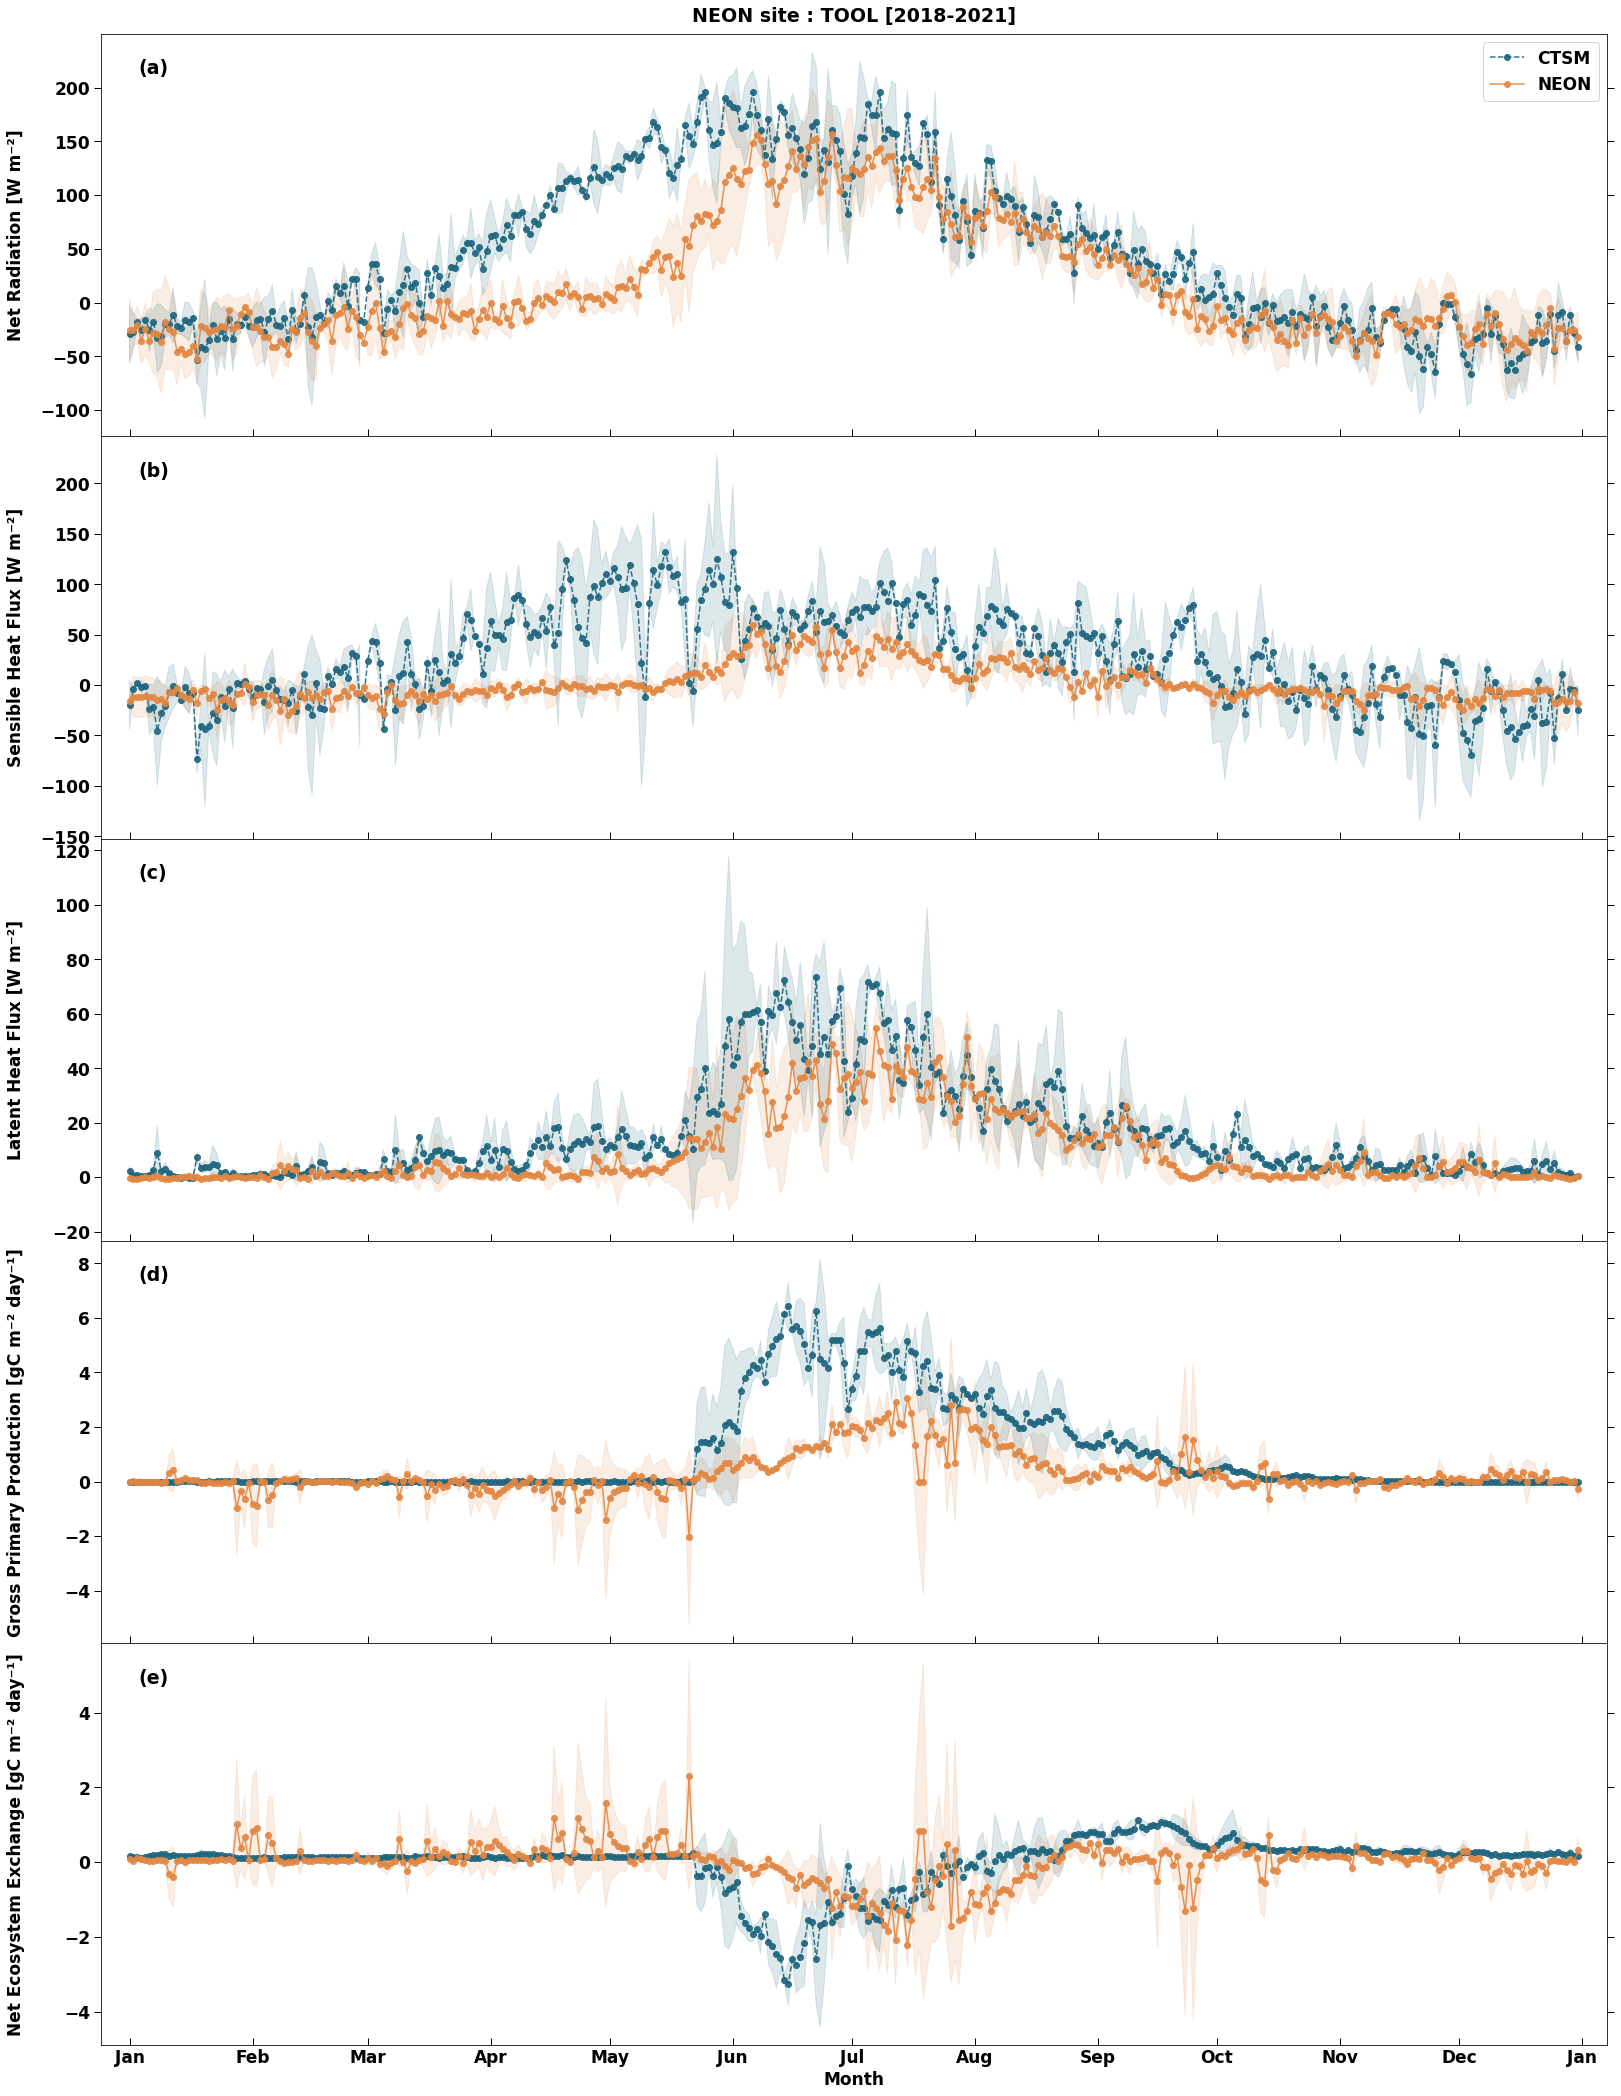

In [18]:
save_switch = True
years = ["2018","2019","2020","2021"]
neon_sites2 = ['TOOL'] # for testing
for neon_site in neon_sites:
    try: 
        start_site = time.time()

        print ('---------------------------')
        print ("Making plots for "+neon_site)
        sim_files =[]
        for year in years:
            sim_path = "/glade/scratch/wwieder/NEON_testV2/archive/"+neon_site+".transient/lnd/hist/"
            #sim_path = "/glade/scratch/wwieder/run_NEON_v2/tools/site_and_regional/archive/"+neon_site+".transient/lnd/hist/"
            #sim_path = "/glade/scratch/negins/neon_v2/tools/site_and_regional/archive/"+neon_site+".transient/lnd/hist/"
            sim_files.extend(sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc"))))

        print("All simulation files for all years: [", len(sim_files), "files]")
        start = time.time()

        ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True,preprocess=preprocess)
        ds_ctsm = fix_time (ds_ctsm)

        end = time.time()
        print("Reading all simulation files took:", end-start, "s.")

        eval_files = []
        for year in years:
            #eval_dir = "/glade/work/negins/neon_scripts/notebooks/evaluation_files_2/"+neon_site
            eval_dir = "/glade/work/wwieder/neon/eval_files/"+neon_site
            eval_files.extend(sorted(glob(join(eval_dir,neon_site+"_eval_"+year+"*.nc"))))

        print ("All evaluation files for all years: [", len(eval_files), "files]")

        start = time.time()

        ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')

        end = time.time()
        print("Reading all observation files took:", end-start, "s.")

        print ("Processing data...")
        #Convert CTSM data to a Pandas Dataframe for easier handling:
        ctsm_vars = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI']

        df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
        df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )

        for var in tqdm.tqdm(ctsm_vars):
            sim_var_name = "sim_"+var
            field = np.ravel ( ds_ctsm[var])     
            df_ctsm[sim_var_name]=field
            #-- shift simulation data by one
            df_ctsm[sim_var_name]=df_ctsm[sim_var_name].shift(-1).values

        #Convert NEON data to a Pandas Dataframe for easier handling:
        eval_vars = ['NEE','FSH','EFLX_LH_TOT','GPP','Rnet']

        df_all = pd.DataFrame({'time':ds_eval.time})

        for var in eval_vars:
            field = np.ravel (ds_eval[var])
            df_all[var]=field
            
            
        # -- merge two pandas dataframe on time
        df_all=df_all.merge(df_ctsm.set_index('time'), on='time', how='left')


        clm_var = 'sim_EFLX_LH_TOT'
        # -- Latent Heat Flux:
        # -- EFLX_LH_TOT = FCEV + FCTR +FGEV
        df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

        clm_var = 'sim_Rnet'
        # -- Net Radiation:
        # -- Rnet = FSA-FIRA
        df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

        clm_var = 'sim_NEE'
        # -- Net Ecosystem Exchange
        # -- NEE = GPP- (AR+HR)
        # -- It seems like the sign are opposite so we calculated negative NEE
        df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

        # convert NEE units from  umolm-2s-1 to gc/m2/s
        df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
        df_all ['GPP']= df_all ['GPP']*(12.01/1000000)
        
        # -- convert gc/m2/s to gc/m2/day
        df_all ['NEE']= df_all['NEE']*60*60*24
        df_all ['sim_NEE']= df_all['sim_NEE']*60*60*24

        df_all ['GPP']= df_all['GPP']*60*60*24
        df_all ['sim_GPP']= df_all['sim_GPP']*60*60*24

        #-- extract year, month, day, hour information from time
        df_all['year'] = df_all['time'].dt.year
        df_all['month'] = df_all['time'].dt.month
        df_all['day'] = df_all['time'].dt.day
        df_all['hour'] = df_all['time'].dt.hour

        #-- Calculate daily average for every day 
        df_daily_allyears = df_all.groupby(['year','month','day']).mean().reset_index()
        df_daily_allyears['time']=pd.to_datetime(df_daily_allyears[["year","month", "day"]])
        
        #-- Calculate average of daily averages for all years
        df_daily = df_daily_allyears.groupby(['month','day']).mean().reset_index()
        df_daily['year']='2020'
        df_daily['time']=pd.to_datetime(df_daily[["year","month", "day"]])

        #-- Calculate Standard Deviation for daily average
        #df_daily_std = df_all.groupby(['year','month','day']).std().reset_index()
        #df_daily_std['time'] = pd.to_datetime(df_daily_std[["year", "month", "day"]])
        
        #-- Calculate Standard Deviation of daily averages over years
        df_daily_std = df_daily_allyears.groupby(['month','day']).std().reset_index()
        df_daily_std['time'] = df_daily['time']

        #-- convert to local time
        tzone_shift = ds_eval.TimeDiffUtcLt
        df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))
        df_all['local_hour'] = df_all['local_time'].dt.hour

        #-- Calculate annual average diel cycle and bias
        diel_df_mean = df_all.groupby('local_hour').mean().reset_index()
        diel_df_std = df_all.groupby('local_hour').std().reset_index()
        diel_df_mean['local_hour_dt']= pd.to_datetime(diel_df_mean['local_hour'], format='%H')

        df_daily['site']=neon_site

        print ("Making climatology plots...")
        color1 = '#e28743'
        #color1 = '#f7aa15'
        color2 = '#1d657e'
        #========================================================================
        fig = plt.figure(num=None, figsize=(27, 37),  facecolor='w', edgecolor='k')
        climatology_tseries_allvars_fig3( fig, df_daily, df_daily_std, all_vars, plot_dir, color1,color2, save_switch)
        
        #fig = plt.figure(num=None, figsize=(27, 37),  facecolor='w', edgecolor='k')
        #climatology_boxplots_allvars_alt_fig3 ( fig, df_daily, df_daily_std, all_vars, plot_dir, color1,color2, save_switch)
        
        
        end_site = time.time()
        print("Making these plots for "+neon_site+" took : ", end_site-start_site, "s.")
        #plt.close('all')

    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass

print ("Making plots for ", len(failed_sites), "sites failed : ")
print (*failed_sites, sep=" \n")

In [16]:
failed_sites

['NIWO', 'PUUM']

In [17]:
neon_sites[-7:]

['TEAK', 'TOOL', 'BARR', 'BONA', 'DEJU', 'HEAL', 'PUUM']